# Examples for running FLORIS

In [1]:
# load modules
from floris.floris import Floris
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Setup floris and process input file

In [2]:
floris = Floris("Input_NREL5MW_SWF_5WT_8mps.json")

## Calculate Wake

In [3]:
import time

t1 = time.time()

floris.farm.flow_field.calculate_wake()

t2 = time.time()

print('Time to compute wake = ', t2-t1, 's')

Time to compute wake =  0.028189897537231445 s


## Compute Velocities at each Turbine

In [4]:
for coord, turbine in floris.farm.turbine_map.items():
    print(str(coord) + ":")
    print("\tCp -", turbine.Cp)
    print("\tCt -", turbine.Ct)
    print("\tpower -", turbine.power)
    print("\tai -", turbine.aI)
    print("\taverage velocity -", turbine.get_average_velocity())

(0.0, 0.0):
	Cp - 0.46328782548262326
	Ct - 0.7661304442831962
	power - 1712005.1679717556
	ai - 0.2581996920407235
	average velocity - 7.85065163365446
(806.0, 0.0):
	Cp - 0.45920069863833074
	Ct - 0.8123597368691396
	power - 949087.4299226647
	ai - 0.2834126832367253
	average velocity - 6.468280905222226
(1612.0, 0.0):
	Cp - 0.4555068094956022
	Ct - 0.8266187480903892
	power - 813672.9635683295
	ai - 0.29180462786746986
	average velocity - 6.16130416443065
(2418.0, 0.0):
	Cp - 0.4539205145297274
	Ct - 0.8327421039477638
	power - 759898.8046758892
	ai - 0.29551412270511435
	average velocity - 6.029476803147518
(3224.0, 0.0):
	Cp - 0.45313048674991385
	Ct - 0.8357917393163931
	power - 734064.8841265555
	ai - 0.2973869077011514
	average velocity - 5.963822382126415


## Visualization Manager for FLORIS 

## Optimize Wind Farm using Wake Steering 

In [5]:
from floris.optimization import wake_steering
import numpy as np

# run FLORIS with no yaw
turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
for k,turbine in enumerate(turbines):
    turbine.yaw_angle = 0.0
floris.farm.flow_field.calculate_wake()
power_initial = np.sum([turbine.power for turbine in turbines])  # determine initial power production

# number of turbines
nTurbs = len(turbines)

# set bounds for the optimization on the yaw angles (deg)
minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

# compute the optimal yaw angles
opt_yaw_angles = wake_steering(floris,minimum_yaw_angle,maximum_yaw_angle)

print('Optimal yaw angles for:')
for i,yaw in enumerate(opt_yaw_angles):
    print('Turbine ', i, ' yaw angle = ', np.degrees(yaw))

Optimal yaw angles for:
Turbine  0  yaw angle =  24.999998526322514
Turbine  1  yaw angle =  24.99999834975587
Turbine  2  yaw angle =  24.999998629994373
Turbine  3  yaw angle =  24.999999236466248
Turbine  4  yaw angle =  9.243414304857213e-08


## Calculate Power Gain

In [6]:
# assign yaw angles to turbines
turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
for i,turbine in enumerate(turbines):
    turbine.yaw_angle = opt_yaw_angles[i]
    
# compute the new wake with yaw angles
floris.farm.flow_field.calculate_wake()

# optimal power 
power_opt = np.sum([turbine.power for turbine in turbines]) 

print('Power increased by ', 100*(power_opt-power_initial)/power_initial, '%')


Power increased by  14.721474338716149 %


## Compute Annual Energy Production

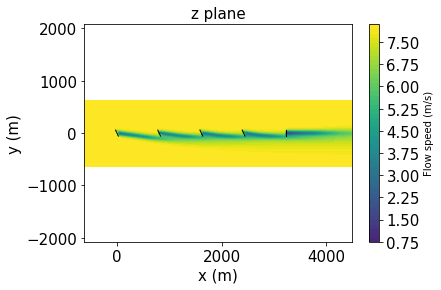

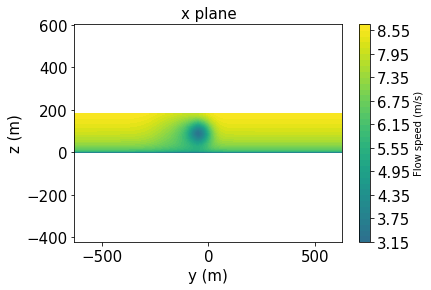

In [8]:
# Visualization
from copy import deepcopy
from floris.visualization import VisualizationManager

ff_viz = deepcopy(floris.farm.flow_field)
grid_resolution = (100, 100, 50)
visualization_manager = VisualizationManager(ff_viz, grid_resolution)
visualization_manager.plot_z_planes([0.5])
visualization_manager.plot_x_planes([0.5])

In [9]:
from scipy.optimize import minimize
from floris.optimization import optimize_plant

t1 = time.time()

# wind speed and wind directions
wind_direction = np.linspace(0,350,36)
wind_speed = np.linspace(0,29,30)

# assume uniform distribution of wind speeds and wind directions 
# NOTE: user should specify specific distributions for their farms
freq = np.ones(len(wind_direction)*len(wind_speed))
freq = freq/np.sum(freq)

# initialize variables
power0    = np.zeros(len(wind_direction)*len(wind_speed))
powerOpt  = np.zeros(len(wind_direction)*len(wind_speed))
yawAngles = np.zeros((len(wind_direction)*len(wind_speed),nTurbs))
windSpeed = np.zeros(len(wind_direction)*len(wind_speed))
windDir   = np.zeros(len(wind_direction)*len(wind_speed))

count = 0

print('Optimizing AEP...')

for i,wd in enumerate(wind_direction):
    for j,ws in enumerate(wind_speed):
        
        print('Wind speed = ', ws, ' Wind direction = ', wd)
        
        # set initial wind direction and wind speed for FLORIS
        floris.farm.flow_field.wind_direction = np.radians(wd - 270) # frame of reference is west
        floris.farm.flow_field.wind_speed = ws
        floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
        floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
        
        # run FLORIS with no yaw
        turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
        for k,turbine in enumerate(turbines):
            turbine.yaw_angle = 0.0
            
        floris.farm.flow_field.calculate_wake()
        turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
        power0[count] = freq[count]*np.nan_to_num(np.sum([turbine.power for turbine in turbines]) )
        
        # optimize FLORIS for yaw
        # set initial conditions
        x0          = [np.radians(1.0) for turbine in turbines]
        bnds        = [(np.radians(minimum_yaw_angle), np.radians(maximum_yaw_angle)) for turbine in turbines]
        
        # optimize plant
        residual_plant = minimize(optimize_plant,x0,args=(floris),method='L-BFGS-B', bounds=bnds)
        turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
        for k,turbine in enumerate(turbines):
            turbine.yaw_angle = residual_plant.x[k]
            yawAngles[count,k] = residual_plant.x[k]
            
        floris.farm.flow_field.calculate_wake()
        turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
        powerOpt[count] = freq[count]*np.nan_to_num(np.sum([turbine.power for turbine in turbines]))
        
        #print('Power gain = ', 100*(powerOpt[count]-power0[count])/power0[count], power0[count],powerOpt[count])
        
        count = count + 1
        
print('AEP gain = ', 100*(np.sum(powerOpt)-np.sum(power0))/np.sum(power0))
t2 = time.time()

print('Total time for AEP optimization = ', t2-t1, 's')
        

Optimizing AEP...
Wind speed =  0.0  Wind direction =  0.0
Wind speed =  1.0  Wind direction =  0.0
Wind speed =  2.0  Wind direction =  0.0
Wind speed =  3.0  Wind direction =  0.0
Wind speed =  4.0  Wind direction =  0.0
Wind speed =  5.0  Wind direction =  0.0
Wind speed =  6.0  Wind direction =  0.0
Wind speed =  7.0  Wind direction =  0.0
Wind speed =  8.0  Wind direction =  0.0
Wind speed =  9.0  Wind direction =  0.0
Wind speed =  10.0  Wind direction =  0.0
Wind speed =  11.0  Wind direction =  0.0
Wind speed =  12.0  Wind direction =  0.0
Wind speed =  13.0  Wind direction =  0.0
Wind speed =  14.0  Wind direction =  0.0
Wind speed =  15.0  Wind direction =  0.0
Wind speed =  16.0  Wind direction =  0.0
Wind speed =  17.0  Wind direction =  0.0
Wind speed =  18.0  Wind direction =  0.0
Wind speed =  19.0  Wind direction =  0.0
Wind speed =  20.0  Wind direction =  0.0
Wind speed =  21.0  Wind direction =  0.0
Wind speed =  22.0  Wind direction =  0.0
Wind speed =  23.0  Wind d

Wind speed =  14.0  Wind direction =  60.0
Wind speed =  15.0  Wind direction =  60.0
Wind speed =  16.0  Wind direction =  60.0
Wind speed =  17.0  Wind direction =  60.0
Wind speed =  18.0  Wind direction =  60.0
Wind speed =  19.0  Wind direction =  60.0
Wind speed =  20.0  Wind direction =  60.0
Wind speed =  21.0  Wind direction =  60.0
Wind speed =  22.0  Wind direction =  60.0
Wind speed =  23.0  Wind direction =  60.0
Wind speed =  24.0  Wind direction =  60.0
Wind speed =  25.0  Wind direction =  60.0
Wind speed =  26.0  Wind direction =  60.0
Wind speed =  27.0  Wind direction =  60.0
Wind speed =  28.0  Wind direction =  60.0
Wind speed =  29.0  Wind direction =  60.0
Wind speed =  0.0  Wind direction =  70.0
Wind speed =  1.0  Wind direction =  70.0
Wind speed =  2.0  Wind direction =  70.0
Wind speed =  3.0  Wind direction =  70.0
Wind speed =  4.0  Wind direction =  70.0
Wind speed =  5.0  Wind direction =  70.0
Wind speed =  6.0  Wind direction =  70.0
Wind speed =  7.0 

Wind speed =  24.0  Wind direction =  120.0
Wind speed =  25.0  Wind direction =  120.0
Wind speed =  26.0  Wind direction =  120.0
Wind speed =  27.0  Wind direction =  120.0
Wind speed =  28.0  Wind direction =  120.0
Wind speed =  29.0  Wind direction =  120.0
Wind speed =  0.0  Wind direction =  130.0
Wind speed =  1.0  Wind direction =  130.0
Wind speed =  2.0  Wind direction =  130.0
Wind speed =  3.0  Wind direction =  130.0
Wind speed =  4.0  Wind direction =  130.0
Wind speed =  5.0  Wind direction =  130.0
Wind speed =  6.0  Wind direction =  130.0
Wind speed =  7.0  Wind direction =  130.0
Wind speed =  8.0  Wind direction =  130.0
Wind speed =  9.0  Wind direction =  130.0
Wind speed =  10.0  Wind direction =  130.0
Wind speed =  11.0  Wind direction =  130.0
Wind speed =  12.0  Wind direction =  130.0
Wind speed =  13.0  Wind direction =  130.0
Wind speed =  14.0  Wind direction =  130.0
Wind speed =  15.0  Wind direction =  130.0
Wind speed =  16.0  Wind direction =  130.

Wind speed =  2.0  Wind direction =  190.0
Wind speed =  3.0  Wind direction =  190.0
Wind speed =  4.0  Wind direction =  190.0
Wind speed =  5.0  Wind direction =  190.0
Wind speed =  6.0  Wind direction =  190.0
Wind speed =  7.0  Wind direction =  190.0
Wind speed =  8.0  Wind direction =  190.0
Wind speed =  9.0  Wind direction =  190.0
Wind speed =  10.0  Wind direction =  190.0
Wind speed =  11.0  Wind direction =  190.0
Wind speed =  12.0  Wind direction =  190.0
Wind speed =  13.0  Wind direction =  190.0
Wind speed =  14.0  Wind direction =  190.0
Wind speed =  15.0  Wind direction =  190.0
Wind speed =  16.0  Wind direction =  190.0
Wind speed =  17.0  Wind direction =  190.0
Wind speed =  18.0  Wind direction =  190.0
Wind speed =  19.0  Wind direction =  190.0
Wind speed =  20.0  Wind direction =  190.0
Wind speed =  21.0  Wind direction =  190.0
Wind speed =  22.0  Wind direction =  190.0
Wind speed =  23.0  Wind direction =  190.0
Wind speed =  24.0  Wind direction =  19

Wind speed =  10.0  Wind direction =  250.0
Wind speed =  11.0  Wind direction =  250.0
Wind speed =  12.0  Wind direction =  250.0
Wind speed =  13.0  Wind direction =  250.0
Wind speed =  14.0  Wind direction =  250.0
Wind speed =  15.0  Wind direction =  250.0
Wind speed =  16.0  Wind direction =  250.0
Wind speed =  17.0  Wind direction =  250.0
Wind speed =  18.0  Wind direction =  250.0
Wind speed =  19.0  Wind direction =  250.0
Wind speed =  20.0  Wind direction =  250.0
Wind speed =  21.0  Wind direction =  250.0
Wind speed =  22.0  Wind direction =  250.0
Wind speed =  23.0  Wind direction =  250.0
Wind speed =  24.0  Wind direction =  250.0
Wind speed =  25.0  Wind direction =  250.0
Wind speed =  26.0  Wind direction =  250.0
Wind speed =  27.0  Wind direction =  250.0
Wind speed =  28.0  Wind direction =  250.0
Wind speed =  29.0  Wind direction =  250.0
Wind speed =  0.0  Wind direction =  260.0
Wind speed =  1.0  Wind direction =  260.0
Wind speed =  2.0  Wind direction 

Wind speed =  18.0  Wind direction =  310.0
Wind speed =  19.0  Wind direction =  310.0
Wind speed =  20.0  Wind direction =  310.0
Wind speed =  21.0  Wind direction =  310.0
Wind speed =  22.0  Wind direction =  310.0
Wind speed =  23.0  Wind direction =  310.0
Wind speed =  24.0  Wind direction =  310.0
Wind speed =  25.0  Wind direction =  310.0
Wind speed =  26.0  Wind direction =  310.0
Wind speed =  27.0  Wind direction =  310.0
Wind speed =  28.0  Wind direction =  310.0
Wind speed =  29.0  Wind direction =  310.0
Wind speed =  0.0  Wind direction =  320.0
Wind speed =  1.0  Wind direction =  320.0
Wind speed =  2.0  Wind direction =  320.0
Wind speed =  3.0  Wind direction =  320.0
Wind speed =  4.0  Wind direction =  320.0
Wind speed =  5.0  Wind direction =  320.0
Wind speed =  6.0  Wind direction =  320.0
Wind speed =  7.0  Wind direction =  320.0
Wind speed =  8.0  Wind direction =  320.0
Wind speed =  9.0  Wind direction =  320.0
Wind speed =  10.0  Wind direction =  320.

NameError: name 'turbines' is not defined